In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from lib.c_index import c_index
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

# Load dataset

In [10]:
path = "dataset/Breast Cancer METABRIC.csv"
df = pd.read_csv(path)
df.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [12]:
print(df.shape)
print(df.columns)
print(df.info())

(2509, 34)
Index(['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery',
       'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
       'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
       'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage',
       'Patient's Vital Status'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column    

In [116]:
df.describe(include=['object', 'bool'])

,Patient ID,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,ER status measured by IHC,ER Status,HER2 status measured by SNP6,...,Integrative Cluster,Primary Tumor Laterality,Oncotree Code,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status,Sex,3-Gene classifier subtype,Patient's Vital Status
count,2509,1955,2509,2509,1917,1980,1980,2426,2469,1980,...,1980,1870,2509,1981,1980,1980,2488,2509,1764,1980
unique,2509,2,2,8,3,2,7,2,2,4,...,11,2,8,2,2,2,2,1,4,3
top,MB-0000,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,Positve,Positive,Neutral,...,8,Left,IDC,Deceased,Positive,Yes,Not Recurred,Female,ER+/HER2- Low Prolif,Living
freq,1,1170,2506,1865,965,1568,700,1817,1825,1436,...,299,973,1865,1144,1040,1173,1486,2509,640,837


In [75]:
patient_meta_cols = ["Patient ID", "Oncotree Code", "Cohort"]
demographic_cols = ['Age at Diagnosis', 'Sex', 'Inferred Menopausal State']
cancer_characteristics_cols = ["Cancer Type", "Cancer Type Detailed", "Cellularity", "Neoplasm Histologic Grade", "Tumor Other Histologic Subtype", "Tumor Size", "Tumor Stage", "Primary Tumor Laterality"]
biomarker_cols = ["ER Status", "ER status measured by IHC", "PR Status", "HER2 Status", "HER2 status measured by SNP6", "Pam50 + Claudin-low subtype", "3-Gene classifier subtype", "Integrative Cluster"]
treatment_cols = ["Type of Breast Surgery", "Hormone Therapy", "Chemotherapy", "Radio Therapy"]
clinical_outcome_cols = ["Overall Survival (Months)", "Overall Survival Status", "Patient's Vital Status", "Relapse Free Status (Months)", "Relapse Free Status"]
clinical_metrics_cols = ["Lymph nodes examined positive", "Mutation Count", "Nottingham prognostic index"]

## Demographic plot

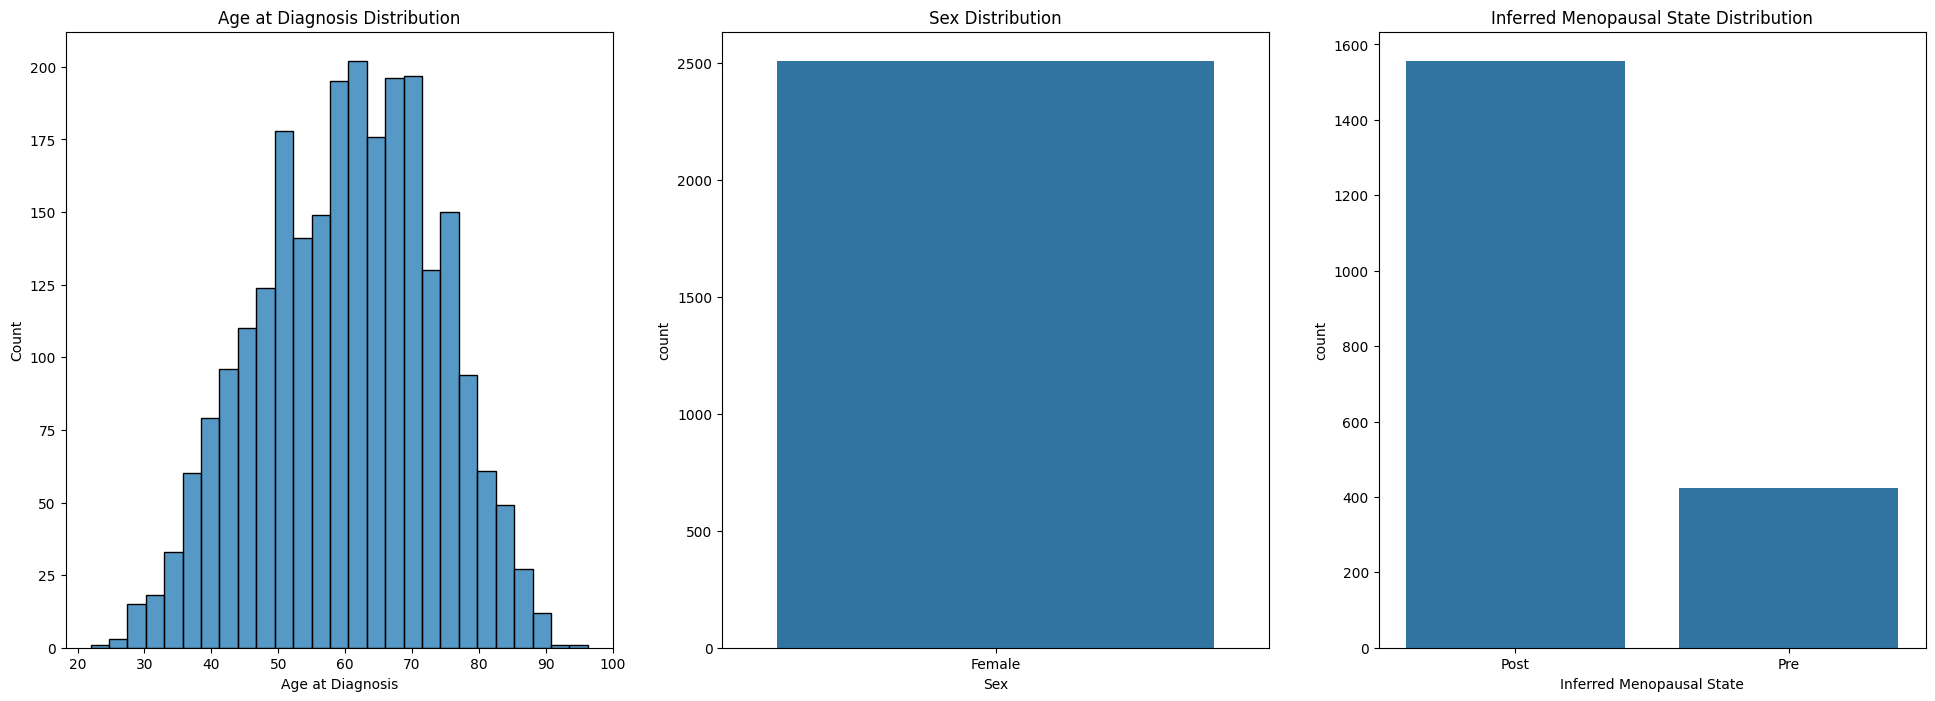

In [242]:
fig, axes = plt.subplots(figsize=(24, 8), ncols=3, nrows=1)
sns.histplot(data=df, x="Age at Diagnosis", ax=axes[0])
sns.countplot(data=df, x="Sex", ax=axes[1])
sns.countplot(data=df, x="Inferred Menopausal State", ax=axes[2])

axes[0].set_title("Age at Diagnosis Distribution")
axes[1].set_title("Sex Distribution")
axes[2].set_title("Inferred Menopausal State Distribution")

plt.show()

## Fill Null Values

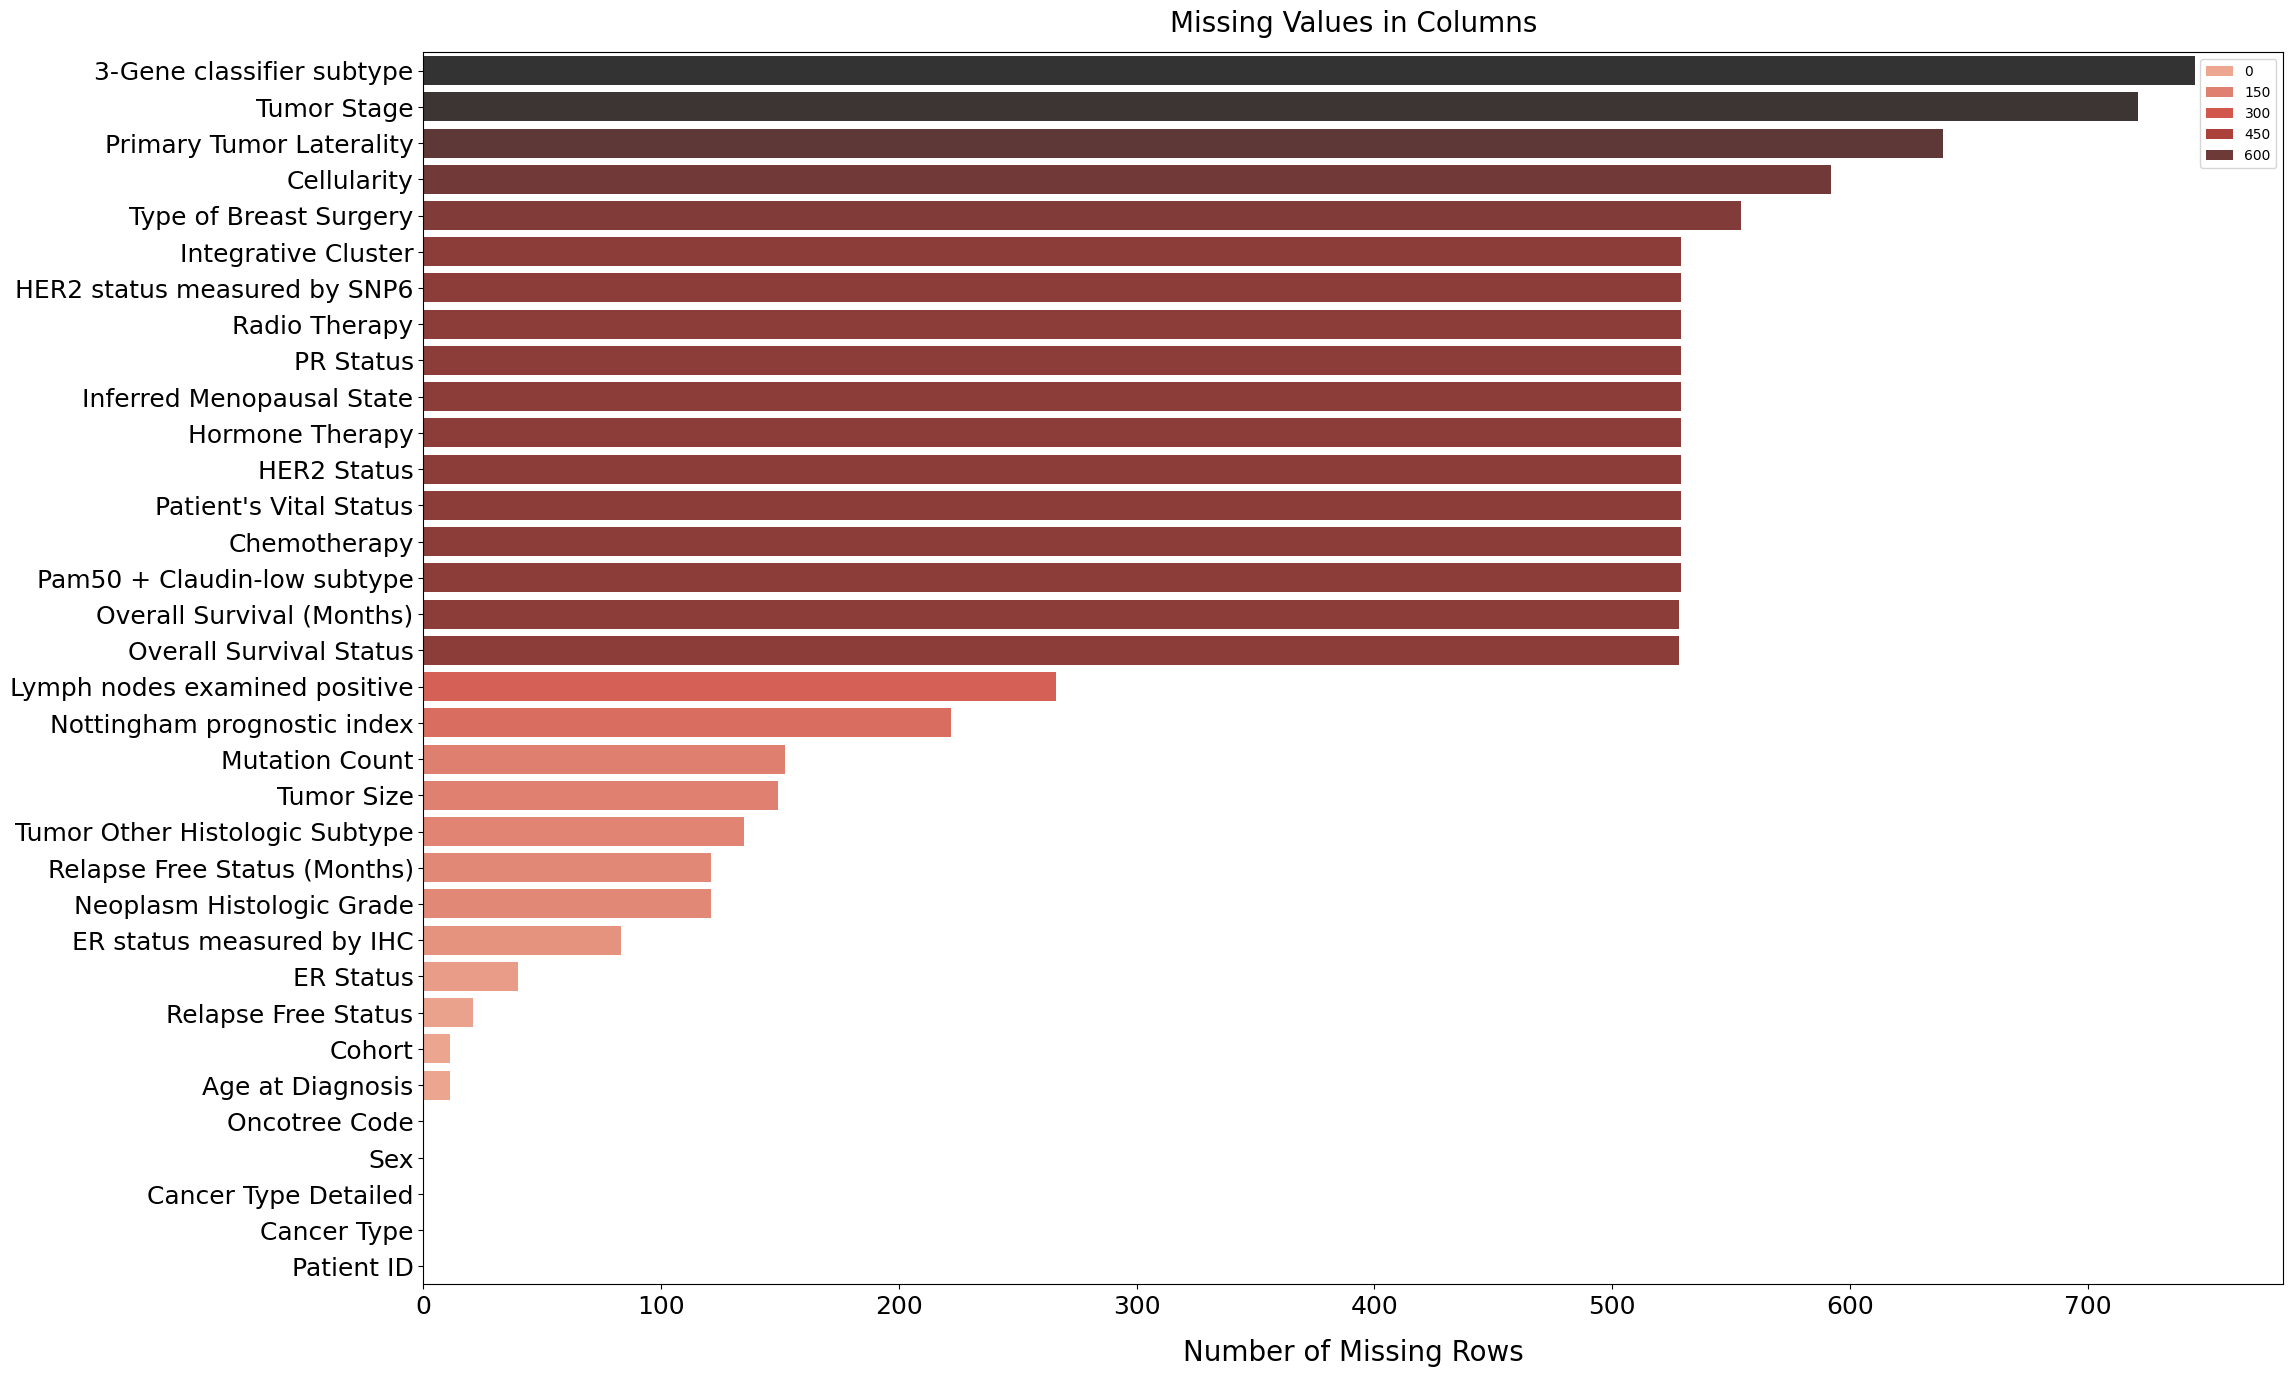

In [82]:
fig = plt.figure(figsize=(24, 16))

sns.barplot(
    x=df.isnull().sum().sort_values(ascending=False).values,
    y=df.isnull().sum().sort_values(ascending=False).index,
    palette="Reds_d",
    hue=df.isnull().sum().sort_values(ascending=False).values
)

plt.xlabel("Number of Missing Rows", size=20, labelpad=15)
plt.ylabel("")
plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)
plt.title("Missing Values in Columns", size=20, pad=15)

plt.show()

In order to fill in the null values, we have to decide which can be reliable for other to depend on. From the above plot, the cancer detailed type can be used to fill the null values as it has 0 missing values. One way of doing that is to group the patients by `Cancer Type Detailed` and then use the most frequent value of their groups to fill in

### Features depend on Cancer Type Detailed

In [ ]:
# Fill event and duration null values with the mean or the most frequent value
grouped_df = df.groupby(["Cancer Type Detailed"])["Relapse Free Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Relapse Free Status"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Relapse Free Status (Months)"].apply(
    lambda x: x.fillna(x.mean())
)
df["Relapse Free Status (Months)"] = grouped_df.sort_index(level=1).values

In [ ]:
# Since the relapse free status has two classes, we have to have two level of grouping
grouped_df = df.groupby(["Cancer Type Detailed", "Relapse Free Status"])["Overall Survival Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Overall Survival Status"] = grouped_df.sort_index(level=2).values
grouped_df = df.groupby(["Cancer Type Detailed", "Overall Survival Status"])["Overall Survival (Months)"].apply(
    lambda x: x.fillna(x.mean())
)
df["Overall Survival (Months)"] = grouped_df.sort_index(level=2).values

Cancer Type Detailed                       Relapse Free Status      
Breast Invasive Ductal Carcinoma           Not Recurred         0         Living
                                                                1         Living
                                           Recurred             2       Deceased
Breast Mixed Ductal and Lobular Carcinoma  Not Recurred         3         Living
                                           Recurred             4       Deceased
                                                                          ...   
Breast Invasive Ductal Carcinoma           Not Recurred         2501      Living
Invasive Breast Carcinoma                  Not Recurred         2502      Living
                                                                2503      Living
                                           Recurred             2504    Deceased
                                                                2505    Deceased
Name: Overall Survival Status, Length: 2

In [243]:
# Fill null values in treatment columns with mode of each cancer type detailed
# For each cancer type detailed, find the mode of each treatment column and fill null values with that mode
grouped_df = df.groupby(["Cancer Type Detailed"])["Chemotherapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Chemotherapy"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Hormone Therapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Hormone Therapy"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Radio Therapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Radio Therapy"] = grouped_df.sort_index(level=1).values